# Cleaning and EDA as preparation
### 0.Preparation
- load github repo for ... 
- create new kernel at project root

### 1. Ideation and Planning

In [1]:
#data loading
import pandas as pd
import numpy as np

coins_raw = pd.read_csv("../data/A14_Conington_coin_data02.csv")
coins_raw.head()
coins_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SITECODE        90 non-null     object 
 1   PERIOD          60 non-null     float64
 2   LU_INT          60 non-null     object 
 3   LU_PROCESS      0 non-null      float64
 4   GP              22 non-null     float64
 5   SGP             2 non-null      float64
 6   CONTEXT         90 non-null     int64  
 7   BASIC_INT       60 non-null     object 
 8   PARENT_CONTEXT  60 non-null     float64
 9   BASIC_PROCESS   0 non-null      float64
 10  ACC_NO          90 non-null     int64  
 11  MATERIAL        90 non-null     object 
 12  COIN_TYPE       42 non-null     object 
 13  COIN_REGIME     42 non-null     object 
 14  RULER           19 non-null     object 
 15  COIN_EDATE      90 non-null     int64  
 16  COIN_LDATE      90 non-null     int64  
 17  DENOMINATION    20 non-null     objec

#### First look at the excavation coin register

The initial `info()` summary shows that the excavation register contains 90 rows and 27 columns, so the dataset is very small and any ML results must be interpreted cautiously. Several core fields (`SITECODE`, `CONTEXT`, `ACC_NO`, `MATERIAL`, `COIN_TYPE`, `COIN_NOTE`) are complete for all coins, making them reliable identifiers and descriptive attributes.

Key numismatic labels are much sparser: `COIN_REGIME` is filled for only 42 coins, `RULER` for 19, and `MINT`/`COIN_CONDITION` for 12, so supervised models will have to work with a reduced subset of rows. Date and diameter columns are numeric but still require cleaning (e.g. coercing invalid entries and treating non‑positive dates as missing), and many process/stratigraphy codes are present but will be excluded from the first ML experiments to keep the feature set focused and interpretable.

Datset and Size: 90 rows, 27 columns

Well populated: SITECODE, CONTEXT, ACC_NO, MATERIAL, COIN_TYPE, COIN_NOTE all have 90 non‑null values.

Sparse: COIN_REGIME = 42, RULER= 19, MINT=12, COIN_CONDITION=12

##### Focused Working Table

In [2]:
cols_keep = [
    "SITECODE",
    "PERIOD",
    "CONTEXT",
    "MATERIAL",
    "COIN_TYPE",
    "COIN_REGIME",
    "RULER",
    "COIN_EDATE",
    "COIN_LDATE",
    "DENOMINATION",
    "DIAMETER",
    "MINT",
    "COIN_CONDITION",
]

coins = coins_raw[cols_keep].copy()
coins.head()


,SITECODE,PERIOD,CONTEXT,MATERIAL,COIN_TYPE,COIN_REGIME,RULER,COIN_EDATE,COIN_LDATE,DENOMINATION,DIAMETER,MINT,COIN_CONDITION
0,A14-32,99.0,320002,COPPER ALLOY,NaN,NaN,NaN,700,900,NaN,NaN,NaN,NaN
1,A14-32,99.0,320002,COPPER ALLOY,COPY,R,CONSTANTIUS II,330,335,NaN,16.0,TRIER,NaN
2,A14-32,99.0,320002,SILVER,COIN,E,NaN,1066,1485,NaN,9.0,NaN,CUTQ
3,A14-32,99.0,320002,COPPER ALLOY,COIN,R,VALENTINIAN I,364,365,NUMMUS,20.0,ARLES,NaN
4,A14-32,99.0,320002,COPPER ALLOY,JETTON,N,NaN,1550,1635,NaN,24.0,NaN,NaN


##### Clean numeric fields and add date features

In [ ]:
import numpy as np

numeric_cols = ["COIN_EDATE", "COIN_LDATE", "DIAMETER"]

for col in numeric_cols:
    coins[col] = pd.to_numeric(coins[col], errors="coerce")

for col in ["COIN_EDATE", "COIN_LDATE"]:
    coins.loc[coins[col] <= 0, col] = np.nan ## remove invalid dates by boolean masking the 0 entries to nan 

coins["mid_date"] = (coins["COIN_EDATE"] + coins["COIN_LDATE"]) / 2
coins["date_span"] = coins["COIN_LDATE"] - coins["COIN_EDATE"]

coins[["COIN_EDATE", "COIN_LDATE", "mid_date", "date_span"]].head()
coins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SITECODE        90 non-null     object 
 1   PERIOD          60 non-null     float64
 2   CONTEXT         90 non-null     int64  
 3   MATERIAL        90 non-null     object 
 4   COIN_TYPE       42 non-null     object 
 5   COIN_REGIME     42 non-null     object 
 6   RULER           19 non-null     object 
 7   COIN_EDATE      59 non-null     float64
 8   COIN_LDATE      61 non-null     float64
 9   DENOMINATION    20 non-null     object 
 10  DIAMETER        43 non-null     float64
 11  MINT            12 non-null     object 
 12  COIN_CONDITION  12 non-null     object 
 13  mid_date        59 non-null     float64
 14  date_span       59 non-null     float64
dtypes: float64(6), int64(1), object(8)
memory usage: 10.7+ KB


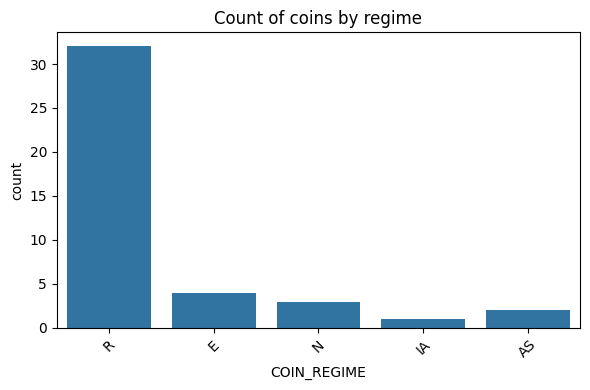

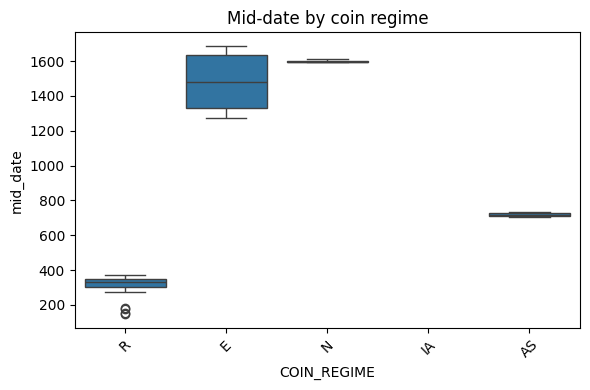

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=coins, x="COIN_REGIME")
plt.xticks(rotation=45)
plt.title("Count of coins by regime")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=coins, x="COIN_REGIME", y="mid_date")
plt.xticks(rotation=45)
plt.title("Mid-date by coin regime")
plt.tight_layout()
plt.show()

##### Interpretation of the regime plots

- The **count plot** shows a very imbalanced assemblage: Roman (`R`) coins dominate the labelled sample (over 30 coins), while medieval (`E`), post-medieval (`N`), Iron Age (`IA`) and Anglo-Saxon (`AS`) regimes are represented by only a handful of coins each. -> Any classifier for `COIN_REGIME` will mostly learn “Roman vs. everything else”. Performance on minority regimes will be unstable.

- The **mid-date boxplot** shows clear chronological separation between regimes. Roman coins have mid-dates clustered in the first few centuries AD, medieval and post-medieval coins cluster much later (around 1300–1650), and Anglo-Saxon coins sit in between (around the 7th–8th centuries). -> Indicates that `mid_date` encodes historically sensible information and will be a strong feature in both clustering and classification.

- The boxplot also reveals that some regimes have **very few data points** (n is so small that the “box” may collapse to a line). -> Limited sample size for non-Roman regimes. ML outcomes must be treated as exploratory.


### 1.5 How many coins can be used for ML?

Not all rows have regime labels or numeric features. Before setting up models, the effective sample sizes are checked to see what is feasible for clustering and classification.


In [5]:
# rows with a regime label
has_regime = coins["COIN_REGIME"].notna()
print("Coins with COIN_REGIME:", has_regime.sum())

# rows usable for clustering (need diameter + mid_date)
has_cluster_feats = coins["DIAMETER"].notna() & coins["mid_date"].notna()
print("Coins with diameter and mid_date:", has_cluster_feats.sum())

# rows usable for classification (regime + diameter + mid_date)
has_cls = has_regime & has_cluster_feats
print("Coins usable for regime classification:", has_cls.sum())


Coins with COIN_REGIME: 42
Coins with diameter and mid_date: 42
Coins usable for regime classification: 40


In [6]:
coins.to_csv("../data/conington_coins_clean.csv", index=False)


## Conclusion 

### Difficulties in cleaning 
- small dataset 
- sparse information
- dates like 99 (code or actual date)
- different possibilities for dating methods